In [ ]:
from keras.preprocessing import image
import keras
from keras.layers import Dense, Lambda, Activation, Input, Concatenate
from keras.models import load_model, Sequential
from keras import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from training_wrapper.custom_layer import OntologyLayer

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.metrics import confusion_matrix

In [2]:
def built_model(n_dishes, n_ingredients, n_concepts, ontology_file, weights_file):
    
    pre_trained = InceptionResNetV2(InceptionResNetV2(weights='imagenet', input_shape=(299,299,3)))
    x = pre_trained.get_layer('avg_pool').output

    outputs = []

    out_SL_1 = Dense(n_dishes)(x)
    out_ML_1 = Dense(n_ingredients)(x)

    outputs.append(out_SL_1)
    outputs.append(out_ML_1)

    x = Concatenate()(outputs)
    x = OntologyLayer((None,n_concepts), ontology_file, False)(x)
    
    out_SL_2 = Lambda( lambda x: x[:, :n_dishes])(x)
    out_ML_2 = Lambda( lambda x: x[:, n_dishes:])(x)
    
    outputs_list = []
    
    out_SL_act = Activation('softmax')(out_SL_2)
    out_ML_act = Activation('sigmoid')(out_ML_2)
    
    outputs_list.append(out_SL_act)
    outputs_list.append(out_ML_act)
    
    model = Model(input=pre_trained.input,output=outputs_list)
    
    model.load_weights(weights_file)
    
    return model

In [3]:
n_dishes = 172
n_ingredients = 353
n_concepts = 525
ontology_file = 'datasets/VireoFood172/meta/ontology_files/Ontologies_prob/DI_ontology_matrix.npy'
weights_file = 'models/Ontology_prob/food_multitask_dish_ingr_ont/epoch_9.h5'

model = built_model(n_dishes, n_ingredients, n_concepts, ontology_file, weights_file)

C:\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[Composite..., inputs=Input('inp...)`


In [4]:
ontology_list = [
                 'datasets/VireoFood172/meta/ontology_files/Ontologies_prob/DI_ontology_matrix.npy',
                 'datasets/VireoFood172/meta/ontology_files/Ontologies_prob_neg/DI_ontology_matrix.npy',
                 'datasets/VireoFood172/meta/ontology_files/Ontologies_prob_neg/DI_II_ontology_matrix.npy',
                 'datasets/VireoFood172/meta/ontology_files/Ontologies_prob_neg/II_ontology_matrix.npy'
                ]

weights_list = [
                'models/Ontology_prob/food_multitask_dish_ingr_ont/epoch_9.h5',
                'models/Ontology_prob_neg/food_multitask_dish_ingr_ont/epoch_10.h5',
                'models/Ontology_prob_neg/food_multitask_dish_ingr_ingr_ingr/epoch_10.h5',
                'models/Ontology_prob_neg/food_multitask_ingr_ingr_ont/epoch_10.h5'
               ]

In [10]:
ontology_list[0]
weights_list[0]

'models/Ontology_prob/food_multitask_dish_ingr_ont/epoch_9.h5'

## Dish List

In [2]:
dish_labels = []
with open('datasets/VireoFood172/dish_labels.txt','r') as f:
    for line in f:
        dish_labels.append(line.replace('\n',''))

In [3]:
dish_lbls_gt = []
with open('datasets/VireoFood172/dish_labels_test_gt.txt','r') as f:
    for line in f:
        dish_lbls_gt.append(int(line.replace('\n','')))
        
dish_lbls_gt=np.array(dish_lbls_gt)

## Precision over dish & ingredients

#### Load images taking into account the directory structure

In [74]:
images_dir = 'datasets/VireoFood172/images'
prediction_file = 'pred_food_multitask_dish_ingr_prob_ont.txt'
prediction_prob_file = 'pred_prob_food_multitask_dish_ingr_prob_ont.txt'
pred_directory = 'results/precision_ingredients'
imgs_to_pred_file = 'datasets/VireoFood172/TE_test.txt'

In [6]:
f = open('datasets/VireoFood172/TE.txt')

In [14]:
imgs_to_pred_file = 'datasets/VireoFood172/TE_test.txt'
images_to_pred = []

with open(imgs_to_pred_file) as f:
    for line in f:
        images_to_pred.append(line.replace('\n',''))

In [41]:
def predict_dishes(model, images_dir, imgs_to_pred_file, pred_directory, prediction_file):    
    
    dish_lbls_pred = []
    images_to_pred = []
    
    if not os.path.exists(pred_directory):
        os.makedirs(pred_directory)
    
    pred_f = open(os.path.join(pred_directory,prediction_file),'w')
    
    with open(imgs_to_pred_file) as f:
        for line in f:
            images_to_pred.append(line.replace('\n',''))
                
    for img_file in images_to_pred: 
    
        #print(images_dir+img_file)
        img = image.load_img(images_dir+img_file,target_size=(299,299,3))
        img = image.img_to_array(img)
        img = img/255
        img = np.expand_dims(img,axis=0)
                
        prediction = model.predict(img)
                
        SL_prediction = prediction[0][0]
                
        dish_lbls_pred.append(SL_prediction.argmax())
        
        pred_f.write(str(SL_prediction.argmax())+'\n')

    dish_lbls_pred = np.array(dish_lbls_pred)

In [122]:
def predict_ingredients(model, images_dir, prob_confidence, imgs_to_pred_file, pred_directory, prediction_file, prediction_prob_file, out_of_confidence_predictions_file):    
    
    ingr_lbls_pred = []
    images_to_pred = []
    
    if not os.path.exists(pred_directory):
        os.makedirs(pred_directory)
    
    pred_f = open(os.path.join(pred_directory,prediction_file),'w')
    pred_prob_f = open(os.path.join(pred_directory,prediction_prob_file),'w')
    
    with open(imgs_to_pred_file) as f:
        for line in f:
            images_to_pred.append(line.replace('\n',''))
                
    for img_num, img_file in enumerate(images_to_pred): 
    
        img = image.load_img(images_dir+img_file,target_size=(299,299,3))
        img = image.img_to_array(img)
        img = img/255
        img = np.expand_dims(img,axis=0)
                
        prediction = model.predict(img)
                
        ML_prediction = prediction[1][0]
        
        #if the highest probability value is less than the confidence value, then take the thre most probable ingredients
        
        if ML_prediction.max() < prob_confidence:
            ingr_idx = ML_prediction.argsort()[::-1][:3]
            ingr_prob = ML_prediction[ingr_idx]
            out_of_confidence_predictions_file.write(img_num)
            
        else:
            ingr_idx = np.where(ML_prediction >= prob_confidence)[0]
            ingr_prob = ML_prediction[ingr_idx]
        
        ingr_idx = np.array(ingr_idx)
        ingr_prob = np.array(ingr_prob)
        
        
        for i,idx in enumerate(ingr_idx):
            if i == len(ingr_idx)-1:
                pred_f.write(str(idx)+'\n')
            else:
                pred_f.write(str(idx)+',')
        
        for i,prob in enumerate(ingr_prob):
            if i == len(ingr_prob)-1:
                pred_prob_f.write(str(prob)+'\n')
            else:
                pred_prob_f.write(str(prob)+',')
    

In [123]:
predict_ingredients(model, images_dir, 0.1, imgs_to_pred_file,pred_directory, prediction_file,prediction_prob_file)

In [124]:
test_ingr_predictions = []
with open('results/precision_ingredients/pred_food_multitask_dish_ingr_prob_ont.txt','r') as f:
    for line in f:
        test_ingr_predictions.append(line.replace('\n',''))

In [125]:
test_ingr_predictions[1].split(',')

['0', '85', '86']

In [67]:
img_file = '3_49.jpg'

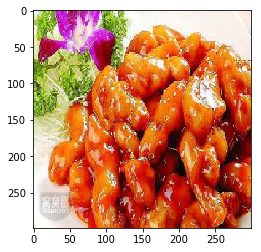

In [68]:
img = image.load_img(dir_images+img_file,target_size=(299,299,3))
img = image.img_to_array(img)
img = img/255
plt.imshow(img)
img = np.expand_dims(img,axis=0)

In [69]:
prediction = mtl_model.predict(img)

In [70]:
SL_prediction = prediction[0][0]
ML_prediction = prediction[1][0]

In [71]:
SL_prediction.argmax()

9